# Starbucks Capstone Challenge

## Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

## Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

## Business Case

From a business standpoint, it would be worth understanding the effectiveness of promotional offers on customer consumption behavior. Products like coffee are an inherent part of individual lifestyle, offer or no offer, individuals will keep on consuming the product.

An Analysis on the promotional offer data will provide insight on the effectiveness of these offers as a tool in bringing customer back to Starbucks brand time and again.

## Problem Statement

Through this Project, we intend to build a Machine Learning Model to predict:

#### *The effectiveness of marketing campaigns by identifying target audience that would respond positively to promotional offers*.

## Data Exploration & Cleaning

In [1]:
#Importing all the required libraries
import pandas as pd
import numpy as np
import math
import json
import datetime 
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
% matplotlib inline

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [3]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [4]:
portfolio.shape

(10, 6)

## Cleaning the portfolio dataset

1. Creating dummy columns for different channels.
2. Renaming id column to offer_id.
3. Creating a validity period column from the duration column --- converting days to hours
4. Dropping unneccessary columns.

In [5]:
#Cleaning portfolio data
channels = ['web', 'email', 'mobile', 'social']
for channel in channels:
    portfolio[channel] = portfolio.channels.apply(lambda x: channel in x)*1
portfolio.rename(columns = {'id':'offer_id'}, inplace = True) 
portfolio['validity_period']=portfolio['duration']*24
portfolio.drop(['channels','duration'],axis=1 ,inplace=True)
portfolio

,difficulty,offer_id,offer_type,reward,web,email,mobile,social,validity_period
0,10,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,0,1,1,1,168
1,10,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1,120
2,0,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,1,0,96
3,5,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,1,0,168
4,20,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,1,0,0,240
5,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1,168
6,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1,240
7,0,5a8bc65990b245e5a138643cd4eb9837,informational,0,0,1,1,1,72
8,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1,120
9,10,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,1,0,168


In [6]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 9 columns):
difficulty         10 non-null int64
offer_id           10 non-null object
offer_type         10 non-null object
reward             10 non-null int64
web                10 non-null int64
email              10 non-null int64
mobile             10 non-null int64
social             10 non-null int64
validity_period    10 non-null int64
dtypes: int64(7), object(2)
memory usage: 800.0+ bytes


## Exploration of Profile dataset

In [7]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [8]:
profile.shape

(17000, 5)

In [9]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [10]:
profile['gender'].value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

In [10]:
missing_percent= profile.isna().mean().round(4) * 100
missing_percent.sort_values(ascending=False)

income              12.79
gender              12.79
id                   0.00
became_member_on     0.00
age                  0.00
dtype: float64

We can see that 12.9% of values are missing for gender and income columns. We can check that further to decide on the imputation strategies.

In [11]:
profile['age'].describe()

count    17000.000000
mean        62.531412
std         26.738580
min         18.000000
25%         45.000000
50%         58.000000
75%         73.000000
max        118.000000
Name: age, dtype: float64

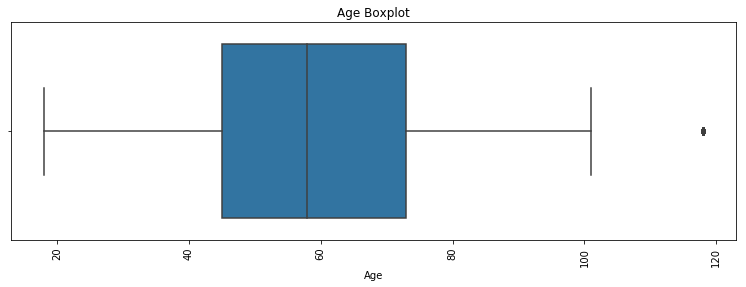

In [12]:
plt.figure(figsize=(13, 4))
sns.boxplot(profile['age'])
plt.title('Age Boxplot')
plt.xlabel('Age')
plt.xticks(rotation = 90)
plt.show();

From the above we can see that, Median age is around 58. 118 seems to be an outlier. 

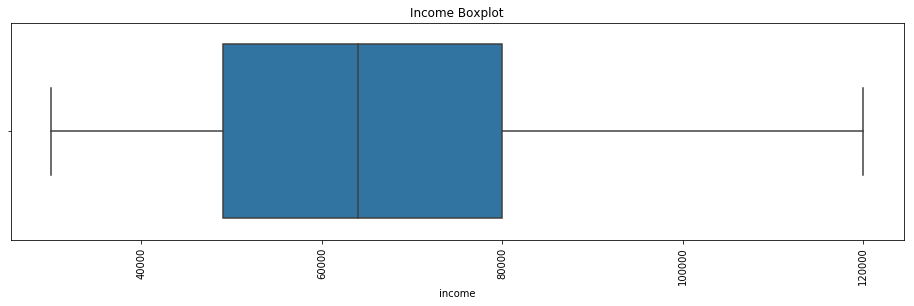

In [13]:
plt.figure(figsize=(16, 4))
sns.boxplot(profile['income'])
plt.title('Income Boxplot')
plt.xlabel('income')
plt.xticks(rotation = 90)
plt.show();

Median income is around 65K

Let us check what are the values for Gender and Income, when age is 118

In [14]:
profile[['gender','income','age']][profile['age']==118].describe()

,income,age
count,0.0,2175.0
mean,NaN,118.0
std,NaN,0.0
min,NaN,118.0
25%,NaN,118.0
50%,NaN,118.0
75%,NaN,118.0
max,NaN,118.0


In [15]:
profile[['gender','income','age']][profile['age']==118].head()

,gender,income,age
0,None,NaN,118
2,None,NaN,118
4,None,NaN,118
6,None,NaN,118
7,None,NaN,118


We can see that when age = 118, both income and gender are NaN. So it's better to drop it from the analysis.

Now let's check the became_member_on column.

In [16]:
chk_date_col=pd.to_datetime(profile['became_member_on'],format='%Y%m%d')
chk_date_col.max()

Timestamp('2018-07-26 00:00:00')

From the above we can see that, we have values till 26-7-2018 only. So to find the time since an individual became member, I am using the current date as 31Dec2018

## Cleaning the profile dataset

1. Dropping rows for age = 118. (As we don't have any other detail for the age group 118, like income and gender both are NULL    when age = 118.)So its better to drop rows wher age = 118 from the analysis.
2. Creating a column member_since from the became_member_on column. It is supposed to show the number of days since, an            individual started using the Starbucks app. So actually it should have been a difference between the current date and the      start date. But since our data is not complete, i.e we have this column details till 26Jul2018 only. So to find the            difference, I am considering current date as 31Dec2018
3. Creating a variable strt_year , which gives us the starting year when an individual became member.
4. Dropping the unwanted columns.                               
                        


In [17]:
#Cleaning profile data
cur_date ="20181231"
profile_clean = profile[profile.age !=118]
profile_clean.rename(columns = {'id':'cust_id'}, inplace = True) 
profile_clean['member_since']= datetime.datetime.strptime(cur_date, '%Y%m%d').date()-pd.to_datetime(profile_clean['became_member_on'],format='%Y%m%d').dt.date
profile_clean['member_since']=profile_clean['member_since'].dt.days
profile_clean['strt_year'] = pd.to_datetime(profile_clean['became_member_on'],format='%Y%m%d').dt.year
profile_clean=profile_clean.drop('became_member_on',axis =1)
profile_clean.head()


/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-

,age,gender,cust_id,income,member_since,strt_year
1,55,F,0610b486422d4921ae7d2bf64640c50b,112000.0,534,2017
3,75,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,601,2017
5,68,M,e2127556f4f64592b11af22de27a7932,70000.0,249,2018
8,65,M,389bc3fa690240e798340f5a15918d5c,53000.0,325,2018
12,58,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,415,2017


In [18]:
profile_clean.describe()

,age,income,member_since,strt_year
count,14825.000000,14825.000000,14825.000000,14825.000000
mean,54.393524,65404.991568,680.478988,2016.620169
std,17.383705,21598.299410,419.205158,1.198245
min,18.000000,30000.000000,158.000000,2013.000000
25%,42.000000,49000.000000,366.000000,2016.000000
50%,55.000000,64000.000000,516.000000,2017.000000
75%,66.000000,80000.000000,955.000000,2017.000000
max,101.000000,120000.000000,1981.000000,2018.000000


In [19]:
profile_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 6 columns):
age             14825 non-null int64
gender          14825 non-null object
cust_id         14825 non-null object
income          14825 non-null float64
member_since    14825 non-null int64
strt_year       14825 non-null int64
dtypes: float64(1), int64(3), object(2)
memory usage: 810.7+ KB


In [20]:
profile_clean.isna().sum()

age             0
gender          0
cust_id         0
income          0
member_since    0
strt_year       0
dtype: int64

So after dropping the outlier age rows, we can see that there are no missing values in our data

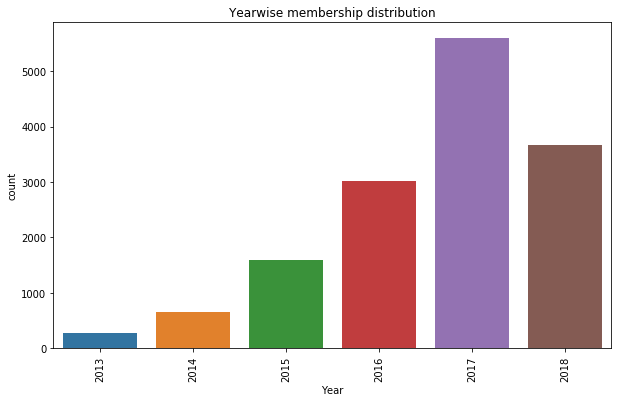

In [21]:
#Plotting yearwise membership distribution
plt.figure(figsize=(10, 6))
sns.countplot(profile_clean['strt_year'])
plt.title('Yearwise membership distribution')
plt.xlabel('Year')
plt.xticks(rotation = 90)
plt.show();

We can see that the app receieved most memberships in the year 2017

Text(0.5,1,'Gender distribution')

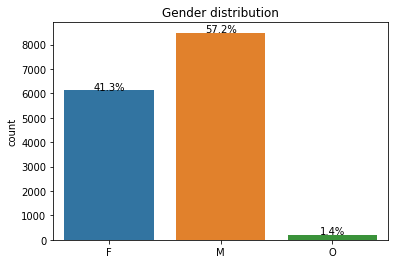

In [22]:
#Plotting Gender distribution
ax = sns.countplot(x="gender", data=profile_clean)
total = float(len(profile_clean))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 5,
            '{:1.1f}%'.format((height/total)*100),
            ha="center") 
    
ax.set_xlabel('')
ax.set_ylabel('count')
ax.set_title('Gender distribution')

We can see that around 57.2% of the total customers are male and 41.3% are female.

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2961: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


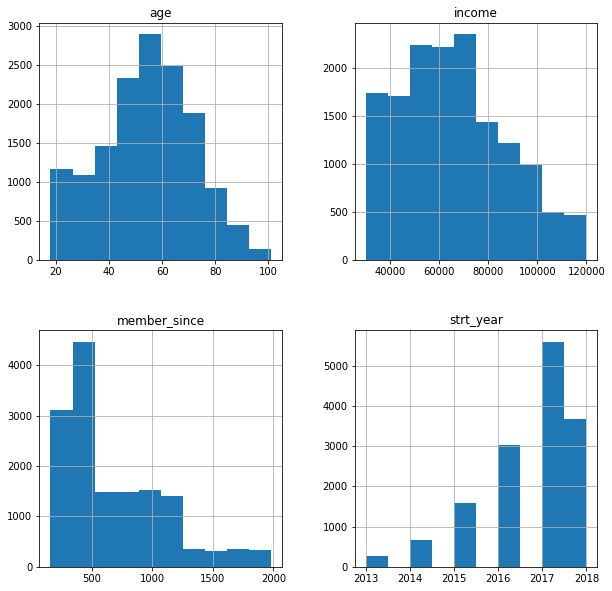

In [23]:
#Exploring numerical variables using histograms
fig = plt.figure(figsize = (10,10))
ax = fig.gca()
profile_clean.hist(ax=ax)
plt.show()

In [24]:
#Creating a function to change the format of income labels
def income(x, pos):
    'The two args are the value and tick position'
    return '{:1.0f}K'.format(x*1e-3)

In [25]:
#creating a function to change the Gender labels
def label(gender): 
    if gender == "M": 
        lab = 'Male'
    elif gender == "F": 
        lab = 'Female'
    else: 
        lab='Other'
    return lab

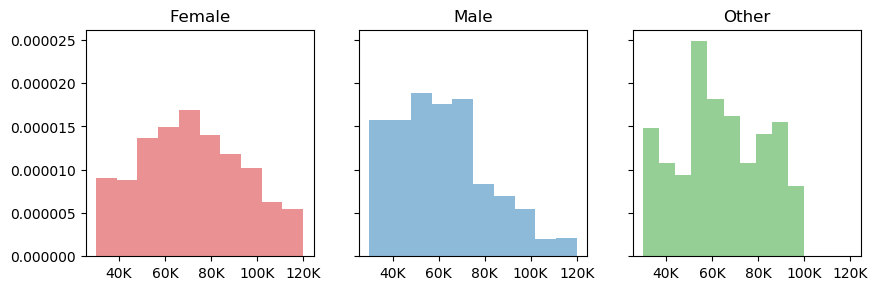

In [26]:
fig, axes = plt.subplots(1, 3, figsize=(10,3), dpi=100, sharex=True, sharey=True)
colors = ['tab:red', 'tab:blue', 'tab:green']

for i, (ax, gender) in enumerate(zip(axes.flatten(), profile_clean.gender.unique())):
    x = profile_clean.loc[profile_clean.gender==gender, 'income']
    ax.xaxis.set_major_formatter(plt.FuncFormatter(income))
    ax.hist(x, alpha=0.5, bins=10, density=True, stacked=True, label=str(gender), color=colors[i])
    ax.set_title(label(gender))


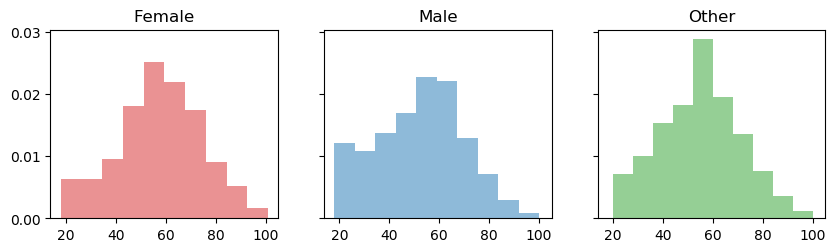

In [27]:
fig, axes = plt.subplots(1, 3, figsize=(10,2.5), dpi=100, sharex=True, sharey=True)
colors = ['tab:red', 'tab:blue', 'tab:green']
for i, (ax, gender) in enumerate(zip(axes.flatten(), profile_clean.gender.unique())):
    x = profile_clean.loc[profile_clean.gender==gender, 'age']
    ax.hist(x, alpha=0.5, bins=10, density=True, stacked=True,  color=colors[i])
    ax.set_title(label(gender))


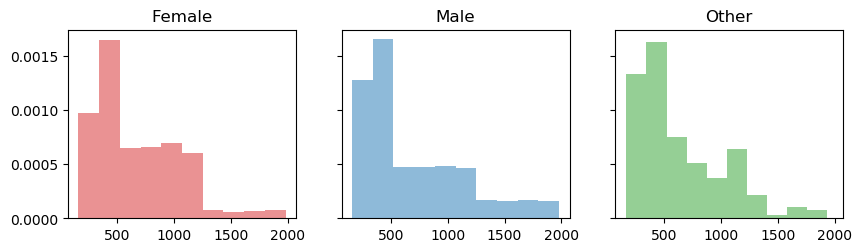

In [28]:
fig, axes = plt.subplots(1, 3, figsize=(10,2.5), dpi=100, sharex=True, sharey=True)
colors = ['tab:red', 'tab:blue', 'tab:green']
for i, (ax, gender) in enumerate(zip(axes.flatten(), profile_clean.gender.unique())):
    x = profile_clean.loc[profile_clean.gender==gender, 'member_since']
    ax.hist(x, alpha=0.5, bins=10, density=True, stacked=True,  color=colors[i])
    ax.set_title(label(gender))


*Let's see the gender wise distribution of Income and age using Violin plots.*

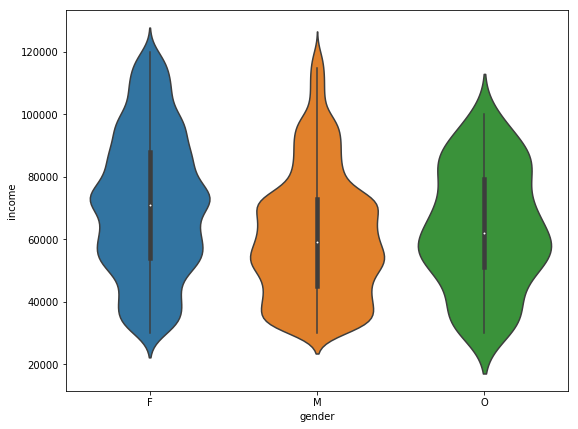

In [29]:
fig, ax = plt.subplots(figsize =(9, 7)) 
sns.violinplot(ax = ax, x = profile_clean["gender"],  
                  y = profile_clean["income"] ) 


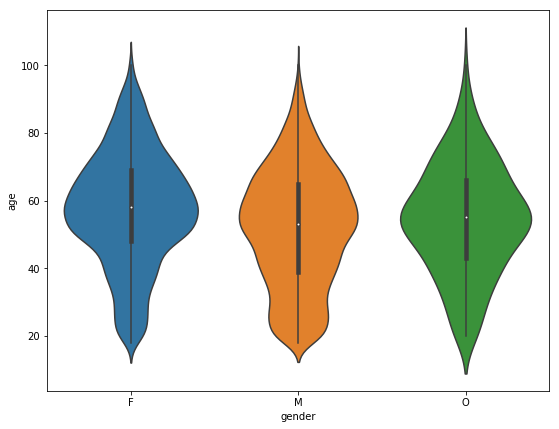

In [30]:
fig, ax = plt.subplots(figsize =(9, 7)) 
sns.violinplot(ax = ax, x = profile_clean["gender"],  
                  y = profile_clean["age"] ) 


## Cleaning the Transcript dataset

1. Expand the value column to create offer_id, amount and reward columns.
2. Dropping ids which are not in the profile data.
3. Creating dummy vars for Event column.
4. Dropping unneccessary columns

In [31]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [32]:
transcript.shape

(306534, 4)

In [33]:
transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [34]:
#Expand the value column to create offer_id, amount and reward columns
transcript_1=pd.concat([transcript, transcript['value'].apply(pd.Series)], axis=1)
transcript_1.head()

,event,person,time,value,offer id,amount,offer_id,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN


In [35]:
#There are 2 offer_id columns... one offer id and other offer_id. We need to combine both and create a single offer_id column
#When offer id column is NaN, the new column should take value from the offer_id column. Else new column = offer id.
#So creating a function for that

def f(row):
    if pd.isnull(row['offer id']):
        val = row['offer_id']
    else:
        val = row['offer id']
    return val

In [36]:
#Applying the function to create offer_id_nw column
transcript_1['offer_id_nw'] = transcript_1.apply(f, axis=1)
transcript_1.head()

,event,person,time,value,offer id,amount,offer_id,reward,offer_id_nw
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN,2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0


In [37]:
#Dropping offer id and offer_id column
transcript_1.drop(['offer id','offer_id'],axis=1,inplace=True)
#Renaming offer_id_nw column to offer_id column
transcript_1.rename(columns={'offer_id_nw':'offer_id'},inplace=True)

In [38]:
transcript_1.drop(['value'],axis=1,inplace=True)

In [39]:
transcript_1.rename(columns = {'person':'cust_id'}, inplace = True) 

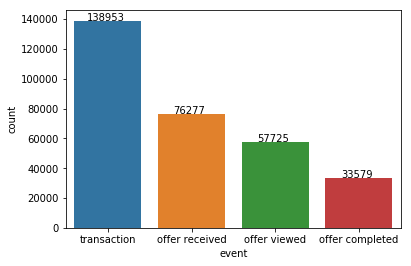

In [40]:
ax = sns.countplot(transcript_1['event'], 
                   order = transcript_1['event'].value_counts().index)
for p, label in zip(ax.patches, transcript_1['event'].value_counts().values):
    ax.annotate(label, (p.get_x()+0.375, p.get_height()+0.15),ha = 'center')

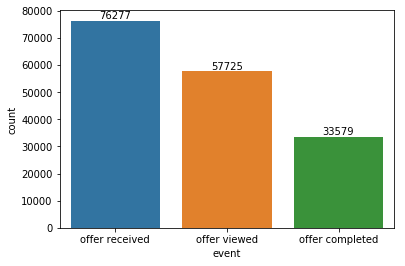

In [41]:
data = transcript_1[transcript_1.event !='transaction']
sns.countplot(data=data, x = 'event')
for i, event in enumerate(transcript.event.value_counts()[1:]):
    plt.text(i, event, event, ha = 'center', va = 'bottom');

In [42]:
chk1 = transcript_1[transcript_1['event']=='offer completed']
chk1['offer_id'].value_counts()

fafdcd668e3743c1bb461111dcafc2a4    5317
2298d6c36e964ae4a3e7e9706d1fb8c2    5156
9b98b8c7a33c4b65b9aebfe6a799e6d9    4354
f19421c1d4aa40978ebb69ca19b0e20d    4296
2906b810c7d4411798c6938adc9daaa5    4017
ae264e3637204a6fb9bb56bc8210ddfd    3688
0b1e1539f2cc45b7b9fa7c272da2e1d7    3420
4d5c57ea9a6940dd891ad53e9dbe8da0    3331
Name: offer_id, dtype: int64

Text(0.5,1,'Offer_ids with Completed Status')

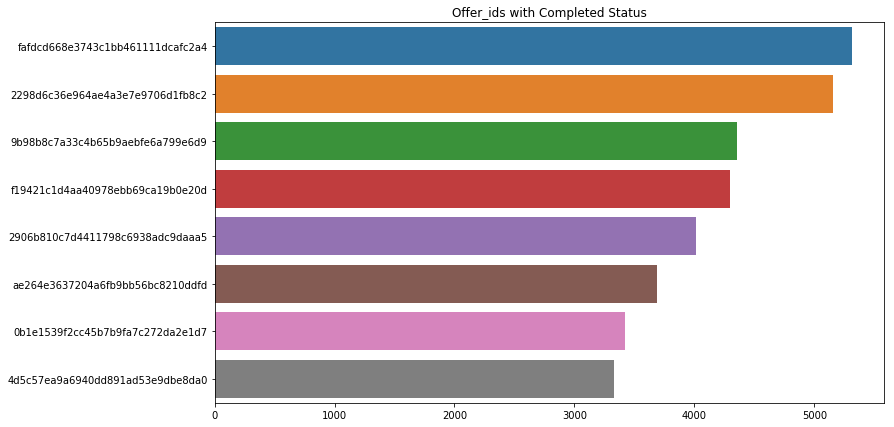

In [43]:
ax = plt.subplots(figsize=(12,7))
ax =sns.countplot(data=chk1, order = chk1['offer_id'].value_counts().index, y = 'offer_id')
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('Offer_ids with Completed Status')

From the above we can see that "fafdcd668e3743c1bb461111dcafc2a4" and "2298d6c36e964ae4a3e7e9706d1fb8c2" are the offer_ids with most completed status.

In [44]:
chk1 = transcript_1[transcript_1['event']=='offer received']
chk1['offer_id'].value_counts()

9b98b8c7a33c4b65b9aebfe6a799e6d9    7677
0b1e1539f2cc45b7b9fa7c272da2e1d7    7668
ae264e3637204a6fb9bb56bc8210ddfd    7658
2298d6c36e964ae4a3e7e9706d1fb8c2    7646
2906b810c7d4411798c6938adc9daaa5    7632
5a8bc65990b245e5a138643cd4eb9837    7618
3f207df678b143eea3cee63160fa8bed    7617
fafdcd668e3743c1bb461111dcafc2a4    7597
4d5c57ea9a6940dd891ad53e9dbe8da0    7593
f19421c1d4aa40978ebb69ca19b0e20d    7571
Name: offer_id, dtype: int64

Text(0.5,1,'Distribution of Offer_ids Received')

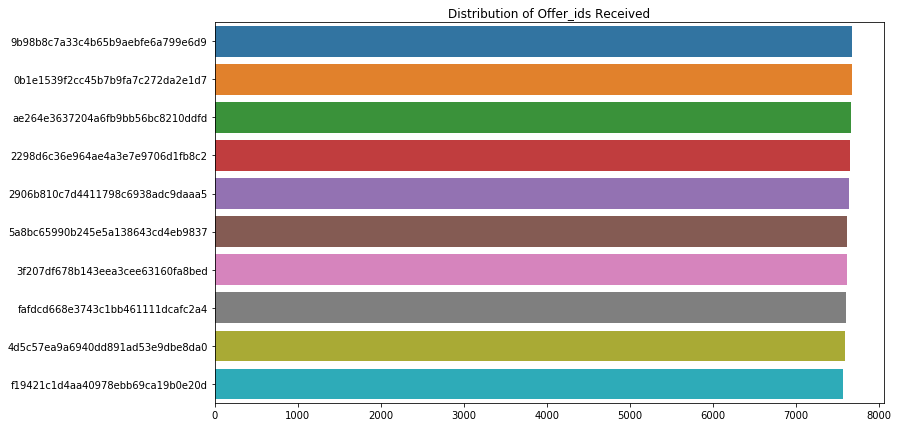

In [45]:
ax = plt.subplots(figsize=(12,7))
ax =sns.countplot(data=chk1, order = chk1['offer_id'].value_counts().index, y = 'offer_id')
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('Distribution of Offer_ids Received')

From the above plot we can see that all offers were sent equally.

In [46]:
chk1 = transcript_1[transcript_1['event']=='offer viewed']
chk1['offer_id'].value_counts()

2298d6c36e964ae4a3e7e9706d1fb8c2    7337
fafdcd668e3743c1bb461111dcafc2a4    7327
4d5c57ea9a6940dd891ad53e9dbe8da0    7298
f19421c1d4aa40978ebb69ca19b0e20d    7264
ae264e3637204a6fb9bb56bc8210ddfd    6716
5a8bc65990b245e5a138643cd4eb9837    6687
9b98b8c7a33c4b65b9aebfe6a799e6d9    4171
3f207df678b143eea3cee63160fa8bed    4144
2906b810c7d4411798c6938adc9daaa5    4118
0b1e1539f2cc45b7b9fa7c272da2e1d7    2663
Name: offer_id, dtype: int64

Text(0.5,1,'Distribution of Offer_ids Viewed')

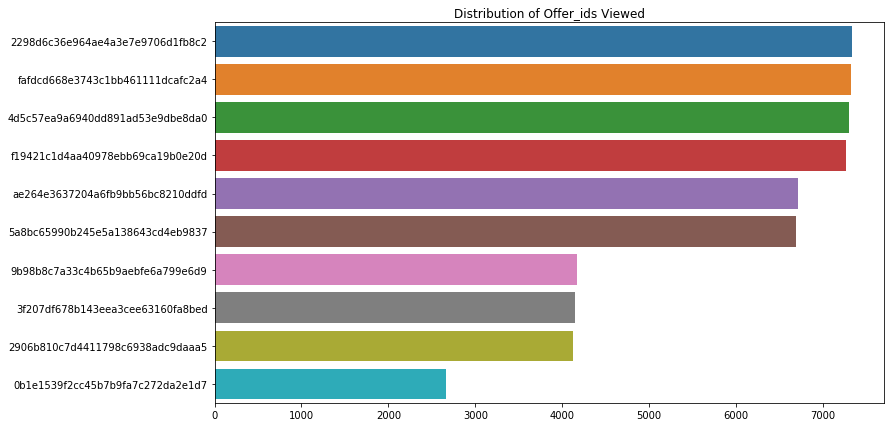

In [47]:
ax = plt.subplots(figsize=(12,7))
ax =sns.countplot(data=chk1, order = chk1['offer_id'].value_counts().index, y = 'offer_id')
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('Distribution of Offer_ids Viewed')

Similarly we can see that  "fafdcd668e3743c1bb461111dcafc2a4" and "2298d6c36e964ae4a3e7e9706d1fb8c2 are the most viewd offer_ids.

In [48]:
transcript_1=transcript_1.sort_values(['cust_id','time'])
transcript_1.head()

,event,cust_id,time,amount,reward,offer_id
55972,offer received,0009655768c64bdeb2e877511632db8f,168,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837
77705,offer viewed,0009655768c64bdeb2e877511632db8f,192,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837
89291,transaction,0009655768c64bdeb2e877511632db8f,228,22.16,NaN,NaN
113605,offer received,0009655768c64bdeb2e877511632db8f,336,NaN,NaN,3f207df678b143eea3cee63160fa8bed
139992,offer viewed,0009655768c64bdeb2e877511632db8f,372,NaN,NaN,3f207df678b143eea3cee63160fa8bed


In [49]:
#Merging transcript data with portfolio data to get the offer datails
transcript_nw=transcript_1.merge(portfolio,how='left',on='offer_id')
transcript_nw.head()

,event,cust_id,time,amount,reward_x,offer_id,difficulty,offer_type,reward_y,web,email,mobile,social,validity_period
0,offer received,0009655768c64bdeb2e877511632db8f,168,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837,0.0,informational,0.0,0.0,1.0,1.0,1.0,72.0
1,offer viewed,0009655768c64bdeb2e877511632db8f,192,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837,0.0,informational,0.0,0.0,1.0,1.0,1.0,72.0
2,transaction,0009655768c64bdeb2e877511632db8f,228,22.16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,offer received,0009655768c64bdeb2e877511632db8f,336,NaN,NaN,3f207df678b143eea3cee63160fa8bed,0.0,informational,0.0,1.0,1.0,1.0,0.0,96.0
4,offer viewed,0009655768c64bdeb2e877511632db8f,372,NaN,NaN,3f207df678b143eea3cee63160fa8bed,0.0,informational,0.0,1.0,1.0,1.0,0.0,96.0


Dropping ids which are not in the profile data

In [50]:
#Keeping only ids which are in profile data
transcript_nw = transcript_nw[transcript_nw['cust_id'].isin(profile_clean['cust_id'])]

In [51]:
#Merging with profile data on the basis of customer id
transcript_clean=transcript_nw.merge(profile_clean,how='left',on='cust_id')
transcript_clean.head()

,event,cust_id,time,amount,reward_x,offer_id,difficulty,offer_type,reward_y,web,email,mobile,social,validity_period,age,gender,income,member_since,strt_year
0,offer received,0009655768c64bdeb2e877511632db8f,168,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837,0.0,informational,0.0,0.0,1.0,1.0,1.0,72.0,33,M,72000.0,619,2017
1,offer viewed,0009655768c64bdeb2e877511632db8f,192,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837,0.0,informational,0.0,0.0,1.0,1.0,1.0,72.0,33,M,72000.0,619,2017
2,transaction,0009655768c64bdeb2e877511632db8f,228,22.16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33,M,72000.0,619,2017
3,offer received,0009655768c64bdeb2e877511632db8f,336,NaN,NaN,3f207df678b143eea3cee63160fa8bed,0.0,informational,0.0,1.0,1.0,1.0,0.0,96.0,33,M,72000.0,619,2017
4,offer viewed,0009655768c64bdeb2e877511632db8f,372,NaN,NaN,3f207df678b143eea3cee63160fa8bed,0.0,informational,0.0,1.0,1.0,1.0,0.0,96.0,33,M,72000.0,619,2017


In [52]:
#Dropping reward_x and reward_y columns
transcript_clean.drop(['reward_x','reward_y'],axis=1,inplace=True)
transcript_clean.head()

,event,cust_id,time,amount,offer_id,difficulty,offer_type,web,email,mobile,social,validity_period,age,gender,income,member_since,strt_year
0,offer received,0009655768c64bdeb2e877511632db8f,168,NaN,5a8bc65990b245e5a138643cd4eb9837,0.0,informational,0.0,1.0,1.0,1.0,72.0,33,M,72000.0,619,2017
1,offer viewed,0009655768c64bdeb2e877511632db8f,192,NaN,5a8bc65990b245e5a138643cd4eb9837,0.0,informational,0.0,1.0,1.0,1.0,72.0,33,M,72000.0,619,2017
2,transaction,0009655768c64bdeb2e877511632db8f,228,22.16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33,M,72000.0,619,2017
3,offer received,0009655768c64bdeb2e877511632db8f,336,NaN,3f207df678b143eea3cee63160fa8bed,0.0,informational,1.0,1.0,1.0,0.0,96.0,33,M,72000.0,619,2017
4,offer viewed,0009655768c64bdeb2e877511632db8f,372,NaN,3f207df678b143eea3cee63160fa8bed,0.0,informational,1.0,1.0,1.0,0.0,96.0,33,M,72000.0,619,2017


In [53]:
#creating dummy vars for different events
dummies = pd.get_dummies(transcript_clean.event)
transcript_clean = pd.concat([transcript_clean, dummies], axis=1)
transcript_clean.drop(['event'],axis=1,inplace=True)
transcript_clean.head()

,cust_id,time,amount,offer_id,difficulty,offer_type,web,email,mobile,social,validity_period,age,gender,income,member_since,strt_year,offer completed,offer received,offer viewed,transaction
0,0009655768c64bdeb2e877511632db8f,168,NaN,5a8bc65990b245e5a138643cd4eb9837,0.0,informational,0.0,1.0,1.0,1.0,72.0,33,M,72000.0,619,2017,0,1,0,0
1,0009655768c64bdeb2e877511632db8f,192,NaN,5a8bc65990b245e5a138643cd4eb9837,0.0,informational,0.0,1.0,1.0,1.0,72.0,33,M,72000.0,619,2017,0,0,1,0
2,0009655768c64bdeb2e877511632db8f,228,22.16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33,M,72000.0,619,2017,0,0,0,1
3,0009655768c64bdeb2e877511632db8f,336,NaN,3f207df678b143eea3cee63160fa8bed,0.0,informational,1.0,1.0,1.0,0.0,96.0,33,M,72000.0,619,2017,0,1,0,0
4,0009655768c64bdeb2e877511632db8f,372,NaN,3f207df678b143eea3cee63160fa8bed,0.0,informational,1.0,1.0,1.0,0.0,96.0,33,M,72000.0,619,2017,0,0,1,0


**Let us explore our data to see that are there any customers who did not receive any offer.**

In [54]:
no_offers_grp =transcript_clean.loc[transcript_clean.groupby(['cust_id'])['offer received'].transform(func=sum)==0,:]

no_offers_grp.head()

,cust_id,time,amount,offer_id,difficulty,offer_type,web,email,mobile,social,validity_period,age,gender,income,member_since,strt_year,offer completed,offer received,offer viewed,transaction
19649,12ede229379747bd8d74ccdc20097ca3,18,16.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,91,M,70000.0,1183,2015,0,0,0,1
19650,12ede229379747bd8d74ccdc20097ca3,324,27.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,91,M,70000.0,1183,2015,0,0,0,1
19651,12ede229379747bd8d74ccdc20097ca3,654,19.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,91,M,70000.0,1183,2015,0,0,0,1
61826,3a4874d8f0ef42b9a1b72294902afea9,324,22.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55,F,88000.0,867,2016,0,0,0,1
61827,3a4874d8f0ef42b9a1b72294902afea9,378,27.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55,F,88000.0,867,2016,0,0,0,1


In [55]:
no_offers_grp.shape

(19, 20)

In [56]:
no_offers_grp['cust_id'].unique()

array(['12ede229379747bd8d74ccdc20097ca3',
       '3a4874d8f0ef42b9a1b72294902afea9',
       'ae8111e7e8cd4b60a8d35c42c1110555',
       'c6e579c6821c41d1a7a6a9cf936e91bb',
       'eb540099db834cf59001f83a4561aef3'], dtype=object)

**There are 5 ids which didn't receive any orders**

In [57]:
transcript_nw['offer_type'].value_counts()

bogo             63834
discount         62311
informational    22660
Name: offer_type, dtype: int64

In [58]:
transcript_clean[transcript_clean['offer received']==1].offer_type.value_counts()

discount         26664
bogo             26537
informational    13300
Name: offer_type, dtype: int64

Text(0.5,1,'Distribution of offer types received')

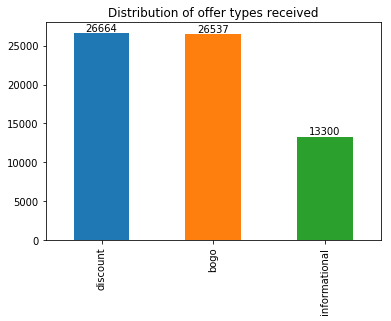

In [59]:
received = transcript_clean[transcript_clean['offer received']==1].offer_type.value_counts()
received.plot(kind='bar')
for i, typ in enumerate(received):
    plt.text(i, typ, typ, ha = 'center', va = 'bottom');
plt.title('Distribution of offer types received')

**From the above, we can see that individuals received almost same amount of Discount and BOGO offers. Informational offers are less.**

Text(0.5,1,'Distribution of offer types viewed')

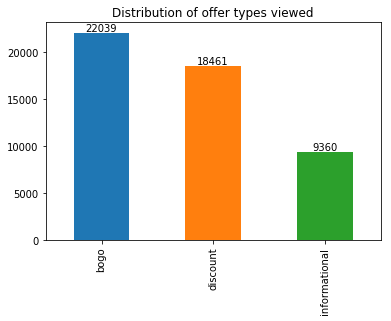

In [60]:
viewed= transcript_clean[transcript_clean['offer viewed']==1].offer_type.value_counts()
viewed.plot(kind='bar')
for i, typ in enumerate(viewed):
    plt.text(i, typ, typ, ha = 'center', va = 'bottom');
plt.title('Distribution of offer types viewed')

**So here we can see that Bogo offers are the most viewed offers**

Text(0.5,1,'Distribution of offer types with completed status')

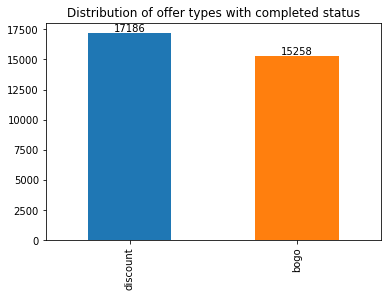

In [61]:
completed = transcript_clean[transcript_clean['offer completed']==1].offer_type.value_counts()
completed.plot(kind='bar')
for i, typ in enumerate(completed):
    plt.text(i, typ, typ, ha = 'center', va = 'bottom');
plt.title('Distribution of offer types with completed status')

**So from the above we can see that informational offers don't have a completed status. Discount offers has the most completed status.**

In [62]:
#create a transaction data which contains only the transaction details.
transaction =transcript_clean[transcript_clean['transaction']==1]
transaction= transaction[['cust_id','time','amount']]
transaction = transaction.reset_index(drop=True)
transaction.head()

,cust_id,time,amount
0,0009655768c64bdeb2e877511632db8f,228,22.16
1,0009655768c64bdeb2e877511632db8f,414,8.57
2,0009655768c64bdeb2e877511632db8f,528,14.11
3,0009655768c64bdeb2e877511632db8f,552,13.56
4,0009655768c64bdeb2e877511632db8f,576,10.27


## Data Aggregation -- Offer level
The cleaning of the transcript data is very tricky as the events are not attributed correctly.

For eg: An event can be marked as completed before it was even  viewed.

Also there are multiple promotions sent for a  customer. Even the same offers can be repeated.

So in the below steps, I am creating different flag variables to correctly capture the events.
ie, An offer should be considered completed only if that event has taken place after it was viewed.
An offer is successfuly completed if it follows the below sequence.
1. For informational offers
    1. After the offer received, it should be viewed. (Viewed time should be within the validity period of the offer).
    2. A customer should spent the required amount (Difficulty) within the offer validity period.
      ie, For a particular customer, there should be transactions >= difficulty(amount required to spent for the completion of that offer)
        and that transactions should be after the offer viewed time and before the offer end time.
2. For Discount or BOGO offers
    1. After the offer received, it should be viewed. (Viewed time should be within the validity period of the offer).
    2. A customer should spent the required amount (Difficulty) within the offer validity period.
    3. There should be an offer completed entry.
       ie, For a particular customer, there should be transactions >= difficulty(amount required to spent for the completion of that offer)
        and that transactions should be after the offer viewed time and before the offer completed time.
     
    

In [63]:
transcript_fnl = transcript_clean.copy()

transcript_fnl_time = transcript_fnl[transcript_fnl.transaction == 0][['cust_id', 'offer_id', 'offer received', 'offer viewed', 'offer completed', 'time']]
    
# re-encode time=0 with time=0.005 (a number close to 0) just to differentiate it from the no-event time.
transcript_fnl_time['time'] = transcript_fnl_time.time.replace(0, 0.005)
 
 #create a unique identifier for each offer sent (because some offers were sent more than once to the same customer)
transcript_fnl_time['received_unique_id'] = transcript_fnl_time[transcript_fnl_time['offer received'] == 1].groupby(['cust_id', 'offer_id']).cumcount()
transcript_fnl_time['viewed_unique_id'] = transcript_fnl_time[transcript_fnl_time['offer viewed'] == 1].groupby(['cust_id', 'offer_id']).cumcount()
transcript_fnl_time['completed_unique_id'] = transcript_fnl_time[transcript_fnl_time['offer completed'] == 1].groupby(['cust_id', 'offer_id']).cumcount()
transcript_fnl_time['events_unique_id'] = transcript_fnl_time[['received_unique_id', 'viewed_unique_id', 'completed_unique_id']].max(axis=1).values
transcript_fnl_time['unique_offer_id'] = transcript_fnl_time['offer_id'] + "-" + transcript_fnl_time['events_unique_id'].apply(lambda x: str(x))
 # create columns which captures the time for each event, like time at which an offer 
# was received, time at which it was viewed etc

transcript_fnl_time['offer_received_time'] = transcript_fnl_time['offer received']*transcript_fnl_time.time
transcript_fnl_time['offer_viewed_time'] = transcript_fnl_time['offer viewed']*transcript_fnl_time.time
transcript_fnl_time['offer_completed_time'] = transcript_fnl_time['offer completed']*transcript_fnl_time.time
transcript_fnl_time = transcript_fnl_time[['cust_id', 'unique_offer_id', 'offer_id', 'time', 'offer_received_time', 'offer_viewed_time', 'offer_completed_time']]

 # unstack values to get to the level of each (cust_id, offer_id) 
 # need to take max value to avoid 0s
transcript_fnl_time_full = transcript_fnl_time.groupby(by=['cust_id', 'unique_offer_id', 'time']).max().unstack()
transcript_fnl_time_full.fillna(0, inplace=True)

# create the final dataset which has details for each offer sent
offers = pd.DataFrame(transcript_fnl_time_full.index.get_level_values('unique_offer_id'), transcript_fnl_time_full.index.get_level_values('cust_id')).reset_index()
offers['offer_received_time'] = transcript_fnl_time_full['offer_received_time'].values.max(axis=1)
offers['offer_viewed_time'] = transcript_fnl_time_full['offer_viewed_time'].values.max(axis=1)
offers['offer_completed_time'] = transcript_fnl_time_full['offer_completed_time'].values.max(axis=1)

 # add information about each offer from portfolio
offers['offer_id'] = offers.unique_offer_id.apply(lambda x: x.split("-")[0])
offers = offers.merge(portfolio, on='offer_id', how='left')

 # calculate offer end time by adding validity period for each offers to the offer received time
offers['offer_end_time'] = offers['offer_received_time']+offers['validity_period']
 
#Create a flag variable to indicate whether the offer was viewed or not
offers['viewed_flg'] = offers.offer_viewed_time.apply(lambda x: 1 if x > 0 else 0)

#create a flag variable to check whether the offer was viewed before the end time
offers['viewed_on_time_flg'] = (offers.offer_viewed_time < offers.offer_end_time)*offers['viewed_flg'] 

#create a flag variable to check whether the offer was completed before the end time
offers['completed_flg'] = offers.offer_completed_time.apply(lambda x: 1 if x > 0 else 0)
offers['completed_on_time'] = (offers.offer_completed_time < offers.offer_end_time)*offers['completed_flg'] 

#Valid completions should be the ones which are done after offer viewed and before the end period.
# Create a flag variable for identifying the valid completed offers.
completed_before_expires = (offers.offer_completed_time < offers.offer_end_time)
completed_after_viewing =(offers.offer_completed_time > offers.offer_viewed_time)*offers['viewed_flg']
offers['completed_valid'] = (completed_after_viewing & completed_before_expires)*offers['completed_flg']

offers.head()

,cust_id,unique_offer_id,offer_received_time,offer_viewed_time,offer_completed_time,offer_id,difficulty,offer_type,reward,web,email,mobile,social,validity_period,offer_end_time,viewed_flg,viewed_on_time_flg,completed_flg,completed_on_time,completed_valid
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5-0.0,576.0,0.0,576.0,2906b810c7d4411798c6938adc9daaa5,10,discount,2,1,1,1,0,168,744.0,0,0,1,1,0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed-0.0,336.0,372.0,0.0,3f207df678b143eea3cee63160fa8bed,0,informational,0,1,1,1,0,96,432.0,1,1,0,0,0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837-0.0,168.0,192.0,0.0,5a8bc65990b245e5a138643cd4eb9837,0,informational,0,0,1,1,1,72,240.0,1,1,0,0,0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d-0.0,408.0,456.0,414.0,f19421c1d4aa40978ebb69ca19b0e20d,5,bogo,5,1,1,1,1,120,528.0,1,1,1,1,0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4-0.0,504.0,540.0,528.0,fafdcd668e3743c1bb461111dcafc2a4,10,discount,2,1,1,1,1,240,744.0,1,1,1,1,0


In [64]:
offers.sort_values(['cust_id','unique_offer_id','offer_received_time'])
offers.head()

,cust_id,unique_offer_id,offer_received_time,offer_viewed_time,offer_completed_time,offer_id,difficulty,offer_type,reward,web,email,mobile,social,validity_period,offer_end_time,viewed_flg,viewed_on_time_flg,completed_flg,completed_on_time,completed_valid
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5-0.0,576.0,0.0,576.0,2906b810c7d4411798c6938adc9daaa5,10,discount,2,1,1,1,0,168,744.0,0,0,1,1,0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed-0.0,336.0,372.0,0.0,3f207df678b143eea3cee63160fa8bed,0,informational,0,1,1,1,0,96,432.0,1,1,0,0,0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837-0.0,168.0,192.0,0.0,5a8bc65990b245e5a138643cd4eb9837,0,informational,0,0,1,1,1,72,240.0,1,1,0,0,0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d-0.0,408.0,456.0,414.0,f19421c1d4aa40978ebb69ca19b0e20d,5,bogo,5,1,1,1,1,120,528.0,1,1,1,1,0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4-0.0,504.0,540.0,528.0,fafdcd668e3743c1bb461111dcafc2a4,10,discount,2,1,1,1,1,240,744.0,1,1,1,1,0


**Giving a very high value for the viewed time of the not viewed offers and making the offer_completed_time for informational offers as the offer_end_time.**

In [65]:
#Giving a very high value for the viewed time of the not viewed offers and 
# making the offer_completed_time for informational offers as the offer_end_time
offers_test = offers.copy()
offers_test.loc[offers_test.viewed_on_time_flg == 0, 'offer_viewed_time'] = 999
offers_test['offer_completed_time']=np.where(offers_test['offer_type'] == 'informational', offers_test['offer_end_time'],offers_test['offer_completed_time'])
offers_test.head()

,cust_id,unique_offer_id,offer_received_time,offer_viewed_time,offer_completed_time,offer_id,difficulty,offer_type,reward,web,email,mobile,social,validity_period,offer_end_time,viewed_flg,viewed_on_time_flg,completed_flg,completed_on_time,completed_valid
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5-0.0,576.0,999.0,576.0,2906b810c7d4411798c6938adc9daaa5,10,discount,2,1,1,1,0,168,744.0,0,0,1,1,0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed-0.0,336.0,372.0,432.0,3f207df678b143eea3cee63160fa8bed,0,informational,0,1,1,1,0,96,432.0,1,1,0,0,0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837-0.0,168.0,192.0,240.0,5a8bc65990b245e5a138643cd4eb9837,0,informational,0,0,1,1,1,72,240.0,1,1,0,0,0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d-0.0,408.0,456.0,414.0,f19421c1d4aa40978ebb69ca19b0e20d,5,bogo,5,1,1,1,1,120,528.0,1,1,1,1,0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4-0.0,504.0,540.0,528.0,fafdcd668e3743c1bb461111dcafc2a4,10,discount,2,1,1,1,1,240,744.0,1,1,1,1,0


In [66]:
#Define a function which creates offer details by looping through each offer id for the 
#given customer and gives details about the success and failure of the offer
def create_cust_offer(cust_id):
    '''
    Create offer details for the given customer
    Input : cust_id -- customer id for the required customer
    Output : A dictionary containing the offer details for the given customer for all the offers received
            It will have column to indicate whether an offer was success or not
            
    '''    
    #Get details of the current customer
    cur_customer = profile_clean[profile_clean['cust_id'] == cust_id]
    # Get offer details for the given customer
    select_offer_data = offers_test['cust_id'] == cust_id
    customer_offer_data = offers_test[select_offer_data]
    customer_offer_data = customer_offer_data.drop(columns='cust_id')
    customer_offer_data = customer_offer_data.reset_index(drop=True)
    # Select transactions for a specific customer
    select_transaction = transaction['cust_id'] == cust_id
    customer_transaction = transaction[select_transaction]
    customer_transaction =customer_transaction.drop(columns='cust_id')
    rows = []
    for idx in range(customer_offer_data.shape[0]):
        # Getting the current offer id and offer type
        cur_offer_id = customer_offer_data.iloc[idx]['unique_offer_id']
        cur_offer_type = customer_offer_data.iloc[idx]['offer_type']
        # Getting the details for current offer
        cur_offer = customer_offer_data.loc[customer_offer_data['unique_offer_id'] == cur_offer_id]
        cur_offer_startime = customer_offer_data.iloc[idx]['offer_received_time']
        cur_offer_endtime = customer_offer_data.iloc[idx]['offer_end_time']
        # Getting a boolean array for all the views offers that fall within the start and end period
        
        select_transaction = np.logical_and(customer_transaction['time'] >=
                                                customer_offer_data .loc[customer_offer_data ['unique_offer_id']==cur_offer_id,'offer_viewed_time'].values[0], 
                                                customer_transaction['time'] <= customer_offer_data.loc[customer_offer_data ['unique_offer_id']==cur_offer_id,'offer_completed_time'].values[0])
                                                 
        #Getting the valid transactions            
        cur_offer_transactions = customer_transaction[select_transaction]
        # Determine whether the current offer was successful ie, If any offer is viewed and current 
        # transaction is greater than the difficulty required for that offer
        cur_offer_successful = (cur_offer_transactions['amount'].sum()>customer_offer_data.iloc[idx]['difficulty'])*customer_offer_data .iloc[idx]['viewed_on_time_flg']
        # Initialize a dictionary that describes the current customer offer
        cur_row = {'cust_id': cust_id,
                   'unique_offer_id': cur_offer_id,
                   'time': cur_offer_startime,
                   'offersuccessful': int(cur_offer_successful),
                   'total_amount': cur_offer_transactions['amount'].sum() }
        cur_row.update(cur_offer.iloc[0,1:].to_dict())
        cur_row.update(cur_customer.iloc[0,1:].to_dict())
        # Update a list of dictionaries that describes the effectiveness of 
        # offers to a specific customer
        rows.append(cur_row)
    return rows

**Now we have to use the above function to create aggregated offer details for each customer.**

Since we are looping through each customer , and for each customer again looping through each orders, it will take a lot of time. So to reduce our future efforts, I am saving it as a csv file, which we can call any time if we want to make any additional change.

In [67]:
cust_data_clean = []
cust_list = list(offers_test['cust_id'].unique())
#Looping through each customer id
for idx in range(len(cust_list)):
    cust_data_clean.extend(create_cust_offer(cust_list[idx]))
cust_data_clean = pd.DataFrame(cust_data_clean)
    # Initialize a list that describes the desired output DataFrame
    # column ordering
column_ordering = ['time', 'cust_id','unique_offer_id','offer_id', 'total_amount',
                       'offersuccessful', 'difficulty', 'validity_period', 'reward',
                       'offer_type','viewed_flg','viewed_on_time_flg','completed_flg','completed_on_time','completed_valid','email', 'mobile', 'social', 'web', 'gender',
                       'income','member_since','strt_year']
cust_data_clean = cust_data_clean[column_ordering]

cust_data_clean = cust_data_clean.sort_values('cust_id')
cust_data_clean.reset_index(drop=True)
cust_data_clean.to_csv('cust_data_clean.csv', index=False)

In [68]:
#Reading back the cleaned csv file
cust_data_clean=pd.read_csv('cust_data_clean.csv')

cust_data_clean.head()

,time,cust_id,unique_offer_id,offer_id,total_amount,offersuccessful,difficulty,validity_period,reward,offer_type,...,completed_on_time,completed_valid,email,mobile,social,web,gender,income,member_since,strt_year
0,576.0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5-0.0,2906b810c7d4411798c6938adc9daaa5,0.00,0,10,168,2,discount,...,1,0,1,1,0,1,M,72000.0,619,2017
1,336.0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed-0.0,3f207df678b143eea3cee63160fa8bed,8.57,1,0,96,0,informational,...,0,0,1,1,0,1,M,72000.0,619,2017
2,168.0,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837-0.0,5a8bc65990b245e5a138643cd4eb9837,22.16,1,0,72,0,informational,...,0,0,1,1,1,0,M,72000.0,619,2017
3,408.0,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d-0.0,f19421c1d4aa40978ebb69ca19b0e20d,0.00,0,5,120,5,bogo,...,1,0,1,1,1,1,M,72000.0,619,2017
4,504.0,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4-0.0,fafdcd668e3743c1bb461111dcafc2a4,0.00,0,10,240,2,discount,...,1,0,1,1,1,1,M,72000.0,619,2017


In [69]:
cust_data_clean.columns

Index(['time', 'cust_id', 'unique_offer_id', 'offer_id', 'total_amount',
       'offersuccessful', 'difficulty', 'validity_period', 'reward',
       'offer_type', 'viewed_flg', 'viewed_on_time_flg', 'completed_flg',
       'completed_on_time', 'completed_valid', 'email', 'mobile', 'social',
       'web', 'gender', 'income', 'member_since', 'strt_year'],
      dtype='object')

In [70]:
cust_data_clean.shape

(66501, 23)

In [71]:
cust_data_clean.offersuccessful.count()

66501

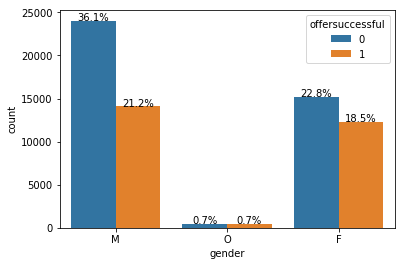

In [72]:
ax = sns.countplot(data=cust_data_clean,
                  x = 'gender',
                 hue = 'offersuccessful')
total = float((cust_data_clean.offersuccessful.count()))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 5,
            '{:1.1f}%'.format((height/total)*100),
            ha="center") 

## Data Aggregation -- Customer level

In [73]:
#Create aggregate data at customer level
cust_data_agg = pd.DataFrame(cust_data_clean.groupby('cust_id').unique_offer_id.count())
cust_data_agg.columns = ['offers_received']
cust_data_agg['total_offers_viewed'] = pd.Series(cust_data_clean.groupby('cust_id')['viewed_on_time_flg'].sum())
cust_data_agg['total_offers_completed'] = pd.Series(cust_data_clean.groupby('cust_id')['completed_valid'].sum())
cust_data_agg['total_successful_offers']=pd.Series(cust_data_clean.groupby('cust_id')['offersuccessful'].sum())
cust_data_agg['total_amounts_spent']=pd.Series(cust_data_clean.groupby('cust_id')['total_amount'].sum())
cust_data_agg['avg_difficulty']=pd.Series(cust_data_clean.groupby('cust_id')['difficulty'].mean())
cust_data_agg['total_rewards']=pd.Series(cust_data_clean.groupby('cust_id')['reward'].sum())
cust_data_agg['email']=pd.Series(cust_data_clean.groupby('cust_id')['email'].sum())
cust_data_agg['mobile']=pd.Series(cust_data_clean.groupby('cust_id')['mobile'].sum())
cust_data_agg['social']=pd.Series(cust_data_clean.groupby('cust_id')['social'].sum())
cust_data_agg['web']=pd.Series(cust_data_clean.groupby('cust_id')['web'].sum())
cust_data_agg.head()

,offers_received,total_offers_viewed,total_offers_completed,total_successful_offers,total_amounts_spent,avg_difficulty,total_rewards,email,mobile,social,web
cust_id,,,,,,,,,,,
0009655768c64bdeb2e877511632db8f,5,4,0,2,30.73,5.00,9,5,5,3,4
0011e0d4e6b944f998e987f904e8c1e5,5,5,3,3,56.03,6.40,13,5,4,2,4
0020c2b971eb4e9188eac86d93036a77,5,2,2,2,34.87,8.00,24,5,5,5,3
0020ccbbb6d84e358d3414a3ff76cffd,4,4,3,4,95.37,4.25,13,4,4,3,3
003d66b6608740288d6cc97a6903f4f0,5,4,2,3,35.06,8.00,9,5,4,3,4


In [74]:
#Create target variable response indicator 
# response_ind = 1 if there is atleast 1 successful offer; else 0;
cust_data_agg['response_ind'] = np.where(cust_data_agg.total_successful_offers > 0, 1, 0)
cust_data_agg.head()

,offers_received,total_offers_viewed,total_offers_completed,total_successful_offers,total_amounts_spent,avg_difficulty,total_rewards,email,mobile,social,web,response_ind
cust_id,,,,,,,,,,,,
0009655768c64bdeb2e877511632db8f,5,4,0,2,30.73,5.00,9,5,5,3,4,1
0011e0d4e6b944f998e987f904e8c1e5,5,5,3,3,56.03,6.40,13,5,4,2,4,1
0020c2b971eb4e9188eac86d93036a77,5,2,2,2,34.87,8.00,24,5,5,5,3,1
0020ccbbb6d84e358d3414a3ff76cffd,4,4,3,4,95.37,4.25,13,4,4,3,3,1
003d66b6608740288d6cc97a6903f4f0,5,4,2,3,35.06,8.00,9,5,4,3,4,1


In [75]:
# Merge profile data

cust_data_agg = cust_data_agg.merge(profile_clean, on='cust_id', how='left')
cust_data_agg.head()

,cust_id,offers_received,total_offers_viewed,total_offers_completed,total_successful_offers,total_amounts_spent,avg_difficulty,total_rewards,email,mobile,social,web,response_ind,age,gender,income,member_since,strt_year
0,0009655768c64bdeb2e877511632db8f,5,4,0,2,30.73,5.00,9,5,5,3,4,1,33,M,72000.0,619,2017
1,0011e0d4e6b944f998e987f904e8c1e5,5,5,3,3,56.03,6.40,13,5,4,2,4,1,40,O,57000.0,356,2018
2,0020c2b971eb4e9188eac86d93036a77,5,2,2,2,34.87,8.00,24,5,5,5,3,1,59,F,90000.0,1032,2016
3,0020ccbbb6d84e358d3414a3ff76cffd,4,4,3,4,95.37,4.25,13,4,4,3,3,1,24,F,60000.0,780,2016
4,003d66b6608740288d6cc97a6903f4f0,5,4,2,3,35.06,8.00,9,5,4,3,4,1,26,F,73000.0,558,2017


In [76]:
print('Overall response rate = {}'.format(cust_data_agg['response_ind'].sum()/len(cust_data_agg)))

Overall response rate = 0.7906207827260459


In [77]:
print('Overall response rate = {}'.format(cust_data_agg['response_ind'].sum()/17000))

Overall response rate = 0.6892352941176471


In [78]:
#Creating aggregate columns for different offer types
bogo= pd.DataFrame(cust_data_clean[cust_data_clean['offer_type'] == 'bogo'].groupby('cust_id').unique_offer_id.count())
bogo.columns = ['total_bogo_offers']
discount= pd.DataFrame(cust_data_clean[cust_data_clean['offer_type'] == 'discount'].groupby('cust_id').unique_offer_id.count())
discount.columns = ['total_discount_offers']
informational= pd.DataFrame(cust_data_clean[cust_data_clean['offer_type'] == 'informational'].groupby('cust_id').unique_offer_id.count())
informational.columns = ['total_informational_offers']
cust_data_agg = cust_data_agg.merge(bogo, on='cust_id', how='left')
cust_data_agg = cust_data_agg.merge(discount, on='cust_id', how='left')
cust_data_agg = cust_data_agg.merge(informational, on='cust_id', how='left')
cust_data_agg.head()

,cust_id,offers_received,total_offers_viewed,total_offers_completed,total_successful_offers,total_amounts_spent,avg_difficulty,total_rewards,email,mobile,...,web,response_ind,age,gender,income,member_since,strt_year,total_bogo_offers,total_discount_offers,total_informational_offers
0,0009655768c64bdeb2e877511632db8f,5,4,0,2,30.73,5.00,9,5,5,...,4,1,33,M,72000.0,619,2017,1.0,2.0,2.0
1,0011e0d4e6b944f998e987f904e8c1e5,5,5,3,3,56.03,6.40,13,5,4,...,4,1,40,O,57000.0,356,2018,1.0,2.0,2.0
2,0020c2b971eb4e9188eac86d93036a77,5,2,2,2,34.87,8.00,24,5,5,...,3,1,59,F,90000.0,1032,2016,2.0,2.0,1.0
3,0020ccbbb6d84e358d3414a3ff76cffd,4,4,3,4,95.37,4.25,13,4,4,...,3,1,24,F,60000.0,780,2016,2.0,1.0,1.0
4,003d66b6608740288d6cc97a6903f4f0,5,4,2,3,35.06,8.00,9,5,4,...,4,1,26,F,73000.0,558,2017,NaN,3.0,2.0


In [79]:
I# Imputing any missing columns with 0 if any
cust_data_agg.fillna(0,inplace=True)
cust_data_agg.head()

,cust_id,offers_received,total_offers_viewed,total_offers_completed,total_successful_offers,total_amounts_spent,avg_difficulty,total_rewards,email,mobile,...,web,response_ind,age,gender,income,member_since,strt_year,total_bogo_offers,total_discount_offers,total_informational_offers
0,0009655768c64bdeb2e877511632db8f,5,4,0,2,30.73,5.00,9,5,5,...,4,1,33,M,72000.0,619,2017,1.0,2.0,2.0
1,0011e0d4e6b944f998e987f904e8c1e5,5,5,3,3,56.03,6.40,13,5,4,...,4,1,40,O,57000.0,356,2018,1.0,2.0,2.0
2,0020c2b971eb4e9188eac86d93036a77,5,2,2,2,34.87,8.00,24,5,5,...,3,1,59,F,90000.0,1032,2016,2.0,2.0,1.0
3,0020ccbbb6d84e358d3414a3ff76cffd,4,4,3,4,95.37,4.25,13,4,4,...,3,1,24,F,60000.0,780,2016,2.0,1.0,1.0
4,003d66b6608740288d6cc97a6903f4f0,5,4,2,3,35.06,8.00,9,5,4,...,4,1,26,F,73000.0,558,2017,0.0,3.0,2.0


In [80]:
#creating a varible to which gives the number of unique offers.
num_unique_offers = pd.DataFrame(cust_data_clean.groupby('cust_id').offer_id.nunique())
num_unique_offers.columns = ['num_unique_offers']
num_unique_offers.head()

,num_unique_offers
cust_id,
0009655768c64bdeb2e877511632db8f,5
0011e0d4e6b944f998e987f904e8c1e5,5
0020c2b971eb4e9188eac86d93036a77,4
0020ccbbb6d84e358d3414a3ff76cffd,4
003d66b6608740288d6cc97a6903f4f0,4


In [81]:
cust_data_agg = cust_data_agg.merge(num_unique_offers, on='cust_id', how='left')
cust_data_agg.head()

,cust_id,offers_received,total_offers_viewed,total_offers_completed,total_successful_offers,total_amounts_spent,avg_difficulty,total_rewards,email,mobile,...,response_ind,age,gender,income,member_since,strt_year,total_bogo_offers,total_discount_offers,total_informational_offers,num_unique_offers
0,0009655768c64bdeb2e877511632db8f,5,4,0,2,30.73,5.00,9,5,5,...,1,33,M,72000.0,619,2017,1.0,2.0,2.0,5
1,0011e0d4e6b944f998e987f904e8c1e5,5,5,3,3,56.03,6.40,13,5,4,...,1,40,O,57000.0,356,2018,1.0,2.0,2.0,5
2,0020c2b971eb4e9188eac86d93036a77,5,2,2,2,34.87,8.00,24,5,5,...,1,59,F,90000.0,1032,2016,2.0,2.0,1.0,4
3,0020ccbbb6d84e358d3414a3ff76cffd,4,4,3,4,95.37,4.25,13,4,4,...,1,24,F,60000.0,780,2016,2.0,1.0,1.0,4
4,003d66b6608740288d6cc97a6903f4f0,5,4,2,3,35.06,8.00,9,5,4,...,1,26,F,73000.0,558,2017,0.0,3.0,2.0,4


In [82]:
#Creating a variable variety ratio, to indicate the preference of variety offers by customers.
cust_data_agg['variety_ratio']= cust_data_agg['num_unique_offers']/cust_data_agg['offers_received']
cust_data_agg.head()

,cust_id,offers_received,total_offers_viewed,total_offers_completed,total_successful_offers,total_amounts_spent,avg_difficulty,total_rewards,email,mobile,...,age,gender,income,member_since,strt_year,total_bogo_offers,total_discount_offers,total_informational_offers,num_unique_offers,variety_ratio
0,0009655768c64bdeb2e877511632db8f,5,4,0,2,30.73,5.00,9,5,5,...,33,M,72000.0,619,2017,1.0,2.0,2.0,5,1.0
1,0011e0d4e6b944f998e987f904e8c1e5,5,5,3,3,56.03,6.40,13,5,4,...,40,O,57000.0,356,2018,1.0,2.0,2.0,5,1.0
2,0020c2b971eb4e9188eac86d93036a77,5,2,2,2,34.87,8.00,24,5,5,...,59,F,90000.0,1032,2016,2.0,2.0,1.0,4,0.8
3,0020ccbbb6d84e358d3414a3ff76cffd,4,4,3,4,95.37,4.25,13,4,4,...,24,F,60000.0,780,2016,2.0,1.0,1.0,4,1.0
4,003d66b6608740288d6cc97a6903f4f0,5,4,2,3,35.06,8.00,9,5,4,...,26,F,73000.0,558,2017,0.0,3.0,2.0,4,0.8


In [83]:
#Creating a variable to measure the proportion of offers viewed.
cust_data_agg['prop_viewed']= cust_data_agg['total_offers_viewed']/cust_data_agg['offers_received']
cust_data_agg.head()

,cust_id,offers_received,total_offers_viewed,total_offers_completed,total_successful_offers,total_amounts_spent,avg_difficulty,total_rewards,email,mobile,...,gender,income,member_since,strt_year,total_bogo_offers,total_discount_offers,total_informational_offers,num_unique_offers,variety_ratio,prop_viewed
0,0009655768c64bdeb2e877511632db8f,5,4,0,2,30.73,5.00,9,5,5,...,M,72000.0,619,2017,1.0,2.0,2.0,5,1.0,0.8
1,0011e0d4e6b944f998e987f904e8c1e5,5,5,3,3,56.03,6.40,13,5,4,...,O,57000.0,356,2018,1.0,2.0,2.0,5,1.0,1.0
2,0020c2b971eb4e9188eac86d93036a77,5,2,2,2,34.87,8.00,24,5,5,...,F,90000.0,1032,2016,2.0,2.0,1.0,4,0.8,0.4
3,0020ccbbb6d84e358d3414a3ff76cffd,4,4,3,4,95.37,4.25,13,4,4,...,F,60000.0,780,2016,2.0,1.0,1.0,4,1.0,1.0
4,003d66b6608740288d6cc97a6903f4f0,5,4,2,3,35.06,8.00,9,5,4,...,F,73000.0,558,2017,0.0,3.0,2.0,4,0.8,0.8


In [84]:
transcript_clean.columns

Index(['cust_id', 'time', 'amount', 'offer_id', 'difficulty', 'offer_type',
       'web', 'email', 'mobile', 'social', 'validity_period', 'age', 'gender',
       'income', 'member_since', 'strt_year', 'offer completed',
       'offer received', 'offer viewed', 'transaction'],
      dtype='object')

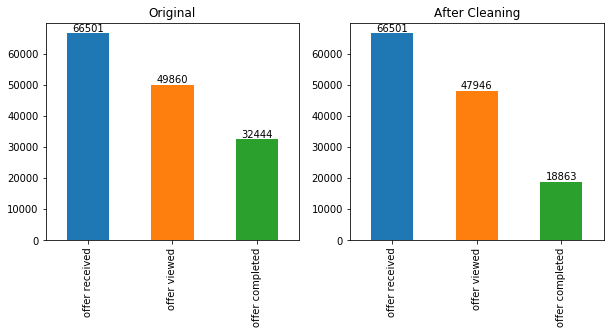

In [85]:
#Plot to indicate the benifits of our cleaning , ie, correctly capturing offers viewed and offers completing
plt.figure(figsize=(10, 4));
plt.subplot(1,2,1)
transcript_nw.event.value_counts()[1:].plot.bar();
plt.title("Original")
for i, num in enumerate(transcript_nw.event.value_counts()[1:]):
    plt.text(i, num, num, ha = 'center', va = 'bottom');
    
plt.subplot(1,2,2)
event = cust_data_agg[['offers_received','total_offers_viewed', 'total_offers_completed']].sum().astype(int)
event.plot.bar();
positions = (0, 1, 2)
labels = ("offer received", "offer viewed", "offer completed")
plt.xticks(positions, labels)
plt.title("After Cleaning");
for i, num in enumerate(event):
    plt.text(i, num, num, ha = 'center', va = 'bottom');

From this we can see that the offers viewed and completed has reduced a lot after cleaning. That is because, now we are correctly attributing the offers viewed and offer completed events. An offer should be viewed within the validity period of that offer. Similarly an offer completed event should occur only after the offer viewed event and also it should be within the validity period. In the cleaning part we have correctly done that.

Text(0.5,0.98,'Distribution of offer types : Original')

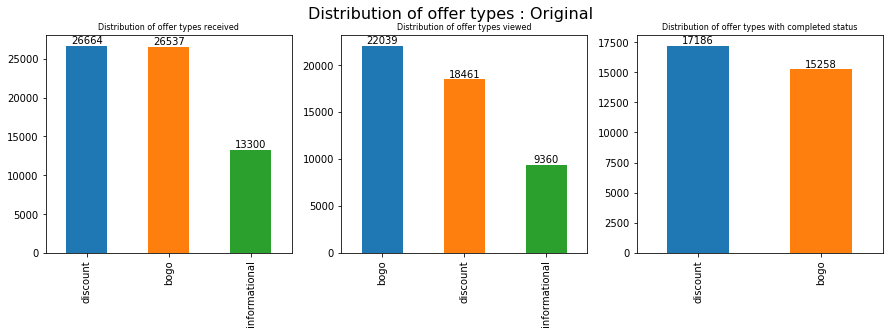

In [86]:
plt.figure(figsize=(15, 4));
plt.subplot(1,3,1)
received = transcript_clean[transcript_clean['offer received']==1].offer_type.value_counts()
received.plot(kind='bar')
for i, num in enumerate(received):
    plt.text(i, num, num, ha = 'center', va = 'bottom');
plt.title('Distribution of offer types received',fontsize=8)
plt.subplot(1,3,2)
viewed= transcript_clean[transcript_clean['offer viewed']==1].offer_type.value_counts()
viewed.plot(kind='bar')
for i, num in enumerate(viewed):
    plt.text(i, num, num, ha = 'center', va = 'bottom');
plt.title('Distribution of offer types viewed',fontsize=8)
plt.subplot(1,3,3)
completed = transcript_clean[transcript_clean['offer completed']==1].offer_type.value_counts()
completed.plot(kind='bar')
for i, num in enumerate(completed):
    plt.text(i, num, num, ha = 'center', va = 'bottom');
plt.title('Distribution of offer types with completed status',fontsize=8)

plt.suptitle('Distribution of offer types : Original',fontsize=16)

Text(0.5,0.98,'Distribution of offer types : After Cleaning')

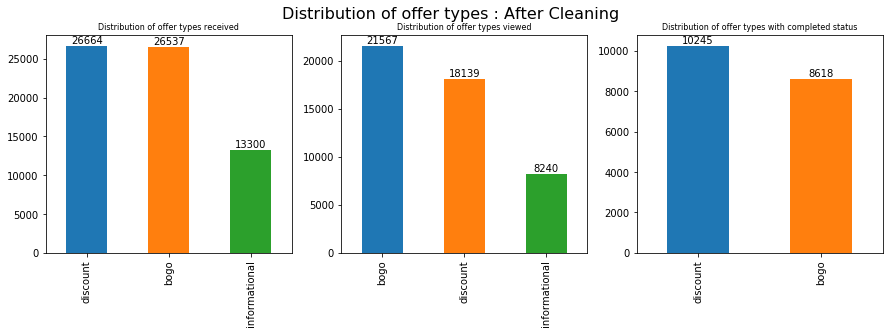

In [87]:
plt.figure(figsize=(15, 4));
plt.subplot(1,3,1)
received = cust_data_clean.offer_type.value_counts()
received.plot(kind='bar')
for i, num in enumerate(received):
    plt.text(i, num, num, ha = 'center', va = 'bottom');
plt.title('Distribution of offer types received',fontsize=8)
plt.subplot(1,3,2)
viewed= cust_data_clean[cust_data_clean['viewed_on_time_flg']==1].offer_type.value_counts()
viewed.plot(kind='bar')
for i, num in enumerate(viewed):
    plt.text(i, num, num, ha = 'center', va = 'bottom');
plt.title('Distribution of offer types viewed',fontsize=8)
plt.subplot(1,3,3)
completed = cust_data_clean[cust_data_clean['completed_valid']==1].offer_type.value_counts()
completed.plot(kind='bar')
for i, num in enumerate(completed):
    plt.text(i, num, num, ha = 'center', va = 'bottom');
plt.title('Distribution of offer types with completed status',fontsize=8)

plt.suptitle('Distribution of offer types : After Cleaning',fontsize=16)


Text(0.5,1,'Distribution of offers with completed status by Gender')

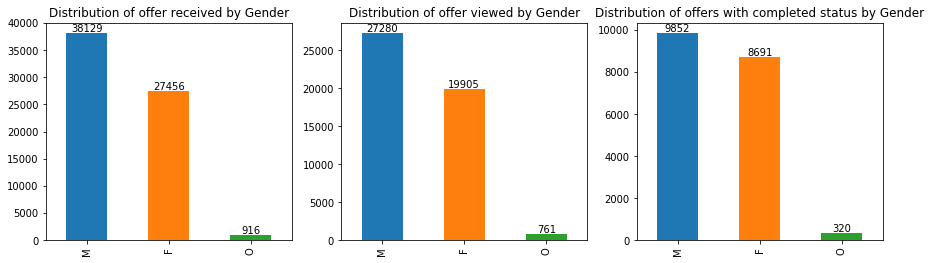

In [88]:
plt.figure(figsize=(15, 4));
plt.subplot(1,3,1)
received = cust_data_clean.gender.value_counts()
received.plot(kind='bar')
for i, num in enumerate(received):
    plt.text(i, num, num, ha = 'center', va = 'bottom');
plt.title('Distribution of offer received by Gender')
plt.subplot(1,3,2)
viewed= cust_data_clean[cust_data_clean['viewed_on_time_flg']==1].gender.value_counts()
viewed.plot(kind='bar')
for i, num in enumerate(viewed):
    plt.text(i, num, num, ha = 'center', va = 'bottom');
plt.title('Distribution of offer viewed by Gender')
plt.subplot(1,3,3)
completed = cust_data_clean[cust_data_clean['completed_valid']==1].gender.value_counts()
completed.plot(kind='bar')
for i, num in enumerate(completed):
    plt.text(i, num, num, ha = 'center', va = 'bottom');
plt.title('Distribution of offers with completed status by Gender')

In [89]:
print('Females:')
print(f"Number of offers completed: {completed[1]}, {round((completed[1]/viewed[1])*100,2)}% of total offers viewed.")
print(f"Number of offers viewed: {viewed[1]}.")

print('\nMales:')
print(f"Number of offers completed: {completed[0]}, {round((completed[0]/viewed[0])*100,2)}% of total offers viewed.")
print(f"Number of offers viewed: {viewed[0]}.")

Females:
Number of offers completed: 8691, 43.66% of total offers viewed.
Number of offers viewed: 19905.

Males:
Number of offers completed: 9852, 36.11% of total offers viewed.
Number of offers viewed: 27280.


**Females are completing more offers, compared to males,around 44%.**

In [90]:
#Creating bins for age

bins = [0,20, 40, 60, 80, np.inf]
names = ['<20', '20-40', '40-60', '60-80', '80+']

cust_data_agg['agerange'] = pd.cut(cust_data_agg['age'], bins, labels=names)
cust_data_agg.head()

,cust_id,offers_received,total_offers_viewed,total_offers_completed,total_successful_offers,total_amounts_spent,avg_difficulty,total_rewards,email,mobile,...,income,member_since,strt_year,total_bogo_offers,total_discount_offers,total_informational_offers,num_unique_offers,variety_ratio,prop_viewed,agerange
0,0009655768c64bdeb2e877511632db8f,5,4,0,2,30.73,5.00,9,5,5,...,72000.0,619,2017,1.0,2.0,2.0,5,1.0,0.8,20-40
1,0011e0d4e6b944f998e987f904e8c1e5,5,5,3,3,56.03,6.40,13,5,4,...,57000.0,356,2018,1.0,2.0,2.0,5,1.0,1.0,20-40
2,0020c2b971eb4e9188eac86d93036a77,5,2,2,2,34.87,8.00,24,5,5,...,90000.0,1032,2016,2.0,2.0,1.0,4,0.8,0.4,40-60
3,0020ccbbb6d84e358d3414a3ff76cffd,4,4,3,4,95.37,4.25,13,4,4,...,60000.0,780,2016,2.0,1.0,1.0,4,1.0,1.0,20-40
4,003d66b6608740288d6cc97a6903f4f0,5,4,2,3,35.06,8.00,9,5,4,...,73000.0,558,2017,0.0,3.0,2.0,4,0.8,0.8,20-40


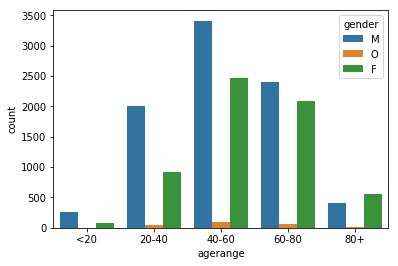

In [91]:
sns.countplot(data=cust_data_agg, x = 'agerange',hue ='gender')

In [92]:
#creating bins for Income
bins = [0,40000,60000, 80000,100000 ,np.inf]
names = ['<40K', '40K-60K', '60K-80K', '80K-100K','100K+']

cust_data_agg['incomerange'] = pd.cut(cust_data_agg['income'], bins, labels=names)
cust_data_agg.head()

,cust_id,offers_received,total_offers_viewed,total_offers_completed,total_successful_offers,total_amounts_spent,avg_difficulty,total_rewards,email,mobile,...,member_since,strt_year,total_bogo_offers,total_discount_offers,total_informational_offers,num_unique_offers,variety_ratio,prop_viewed,agerange,incomerange
0,0009655768c64bdeb2e877511632db8f,5,4,0,2,30.73,5.00,9,5,5,...,619,2017,1.0,2.0,2.0,5,1.0,0.8,20-40,60K-80K
1,0011e0d4e6b944f998e987f904e8c1e5,5,5,3,3,56.03,6.40,13,5,4,...,356,2018,1.0,2.0,2.0,5,1.0,1.0,20-40,40K-60K
2,0020c2b971eb4e9188eac86d93036a77,5,2,2,2,34.87,8.00,24,5,5,...,1032,2016,2.0,2.0,1.0,4,0.8,0.4,40-60,80K-100K
3,0020ccbbb6d84e358d3414a3ff76cffd,4,4,3,4,95.37,4.25,13,4,4,...,780,2016,2.0,1.0,1.0,4,1.0,1.0,20-40,40K-60K
4,003d66b6608740288d6cc97a6903f4f0,5,4,2,3,35.06,8.00,9,5,4,...,558,2017,0.0,3.0,2.0,4,0.8,0.8,20-40,60K-80K


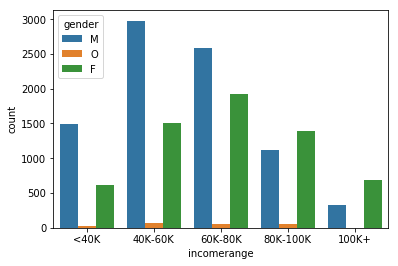

In [93]:
sns.countplot(data=cust_data_agg, x = 'incomerange',hue ='gender')

In [94]:
#Creating dummy variables for age, gender and income categories
for feat in ['gender','agerange','incomerange']:
    cust_data_agg = pd.concat([cust_data_agg, pd.get_dummies(cust_data_agg[feat],prefix = 'ind', prefix_sep='_')],axis=1)
    cust_data_agg.drop(feat,axis=1,inplace=True)
cust_data_agg.head()

,cust_id,offers_received,total_offers_viewed,total_offers_completed,total_successful_offers,total_amounts_spent,avg_difficulty,total_rewards,email,mobile,...,ind_<20,ind_20-40,ind_40-60,ind_60-80,ind_80+,ind_<40K,ind_40K-60K,ind_60K-80K,ind_80K-100K,ind_100K+
0,0009655768c64bdeb2e877511632db8f,5,4,0,2,30.73,5.00,9,5,5,...,0,1,0,0,0,0,0,1,0,0
1,0011e0d4e6b944f998e987f904e8c1e5,5,5,3,3,56.03,6.40,13,5,4,...,0,1,0,0,0,0,1,0,0,0
2,0020c2b971eb4e9188eac86d93036a77,5,2,2,2,34.87,8.00,24,5,5,...,0,0,1,0,0,0,0,0,1,0
3,0020ccbbb6d84e358d3414a3ff76cffd,4,4,3,4,95.37,4.25,13,4,4,...,0,1,0,0,0,0,1,0,0,0
4,003d66b6608740288d6cc97a6903f4f0,5,4,2,3,35.06,8.00,9,5,4,...,0,1,0,0,0,0,0,1,0,0


In [95]:
cust_data_agg.head()

,cust_id,offers_received,total_offers_viewed,total_offers_completed,total_successful_offers,total_amounts_spent,avg_difficulty,total_rewards,email,mobile,...,ind_<20,ind_20-40,ind_40-60,ind_60-80,ind_80+,ind_<40K,ind_40K-60K,ind_60K-80K,ind_80K-100K,ind_100K+
0,0009655768c64bdeb2e877511632db8f,5,4,0,2,30.73,5.00,9,5,5,...,0,1,0,0,0,0,0,1,0,0
1,0011e0d4e6b944f998e987f904e8c1e5,5,5,3,3,56.03,6.40,13,5,4,...,0,1,0,0,0,0,1,0,0,0
2,0020c2b971eb4e9188eac86d93036a77,5,2,2,2,34.87,8.00,24,5,5,...,0,0,1,0,0,0,0,0,1,0
3,0020ccbbb6d84e358d3414a3ff76cffd,4,4,3,4,95.37,4.25,13,4,4,...,0,1,0,0,0,0,1,0,0,0
4,003d66b6608740288d6cc97a6903f4f0,5,4,2,3,35.06,8.00,9,5,4,...,0,1,0,0,0,0,0,1,0,0


In [96]:
#Dropping unwanted columns
cust_data_agg.drop(['age','income','total_successful_offers','total_amounts_spent','total_offers_completed'],axis=1,inplace = True)

In [97]:
#Checking if there are any missing values
cust_data_agg.isna().sum()

cust_id                       0
offers_received               0
total_offers_viewed           0
avg_difficulty                0
total_rewards                 0
email                         0
mobile                        0
social                        0
web                           0
response_ind                  0
member_since                  0
strt_year                     0
total_bogo_offers             0
total_discount_offers         0
total_informational_offers    0
num_unique_offers             0
variety_ratio                 0
prop_viewed                   0
ind_F                         0
ind_M                         0
ind_O                         0
ind_<20                       0
ind_20-40                     0
ind_40-60                     0
ind_60-80                     0
ind_80+                       0
ind_<40K                      0
ind_40K-60K                   0
ind_60K-80K                   0
ind_80K-100K                  0
ind_100K+                     0
dtype: i

In [98]:
cust_data_agg.columns

Index(['cust_id', 'offers_received', 'total_offers_viewed', 'avg_difficulty',
       'total_rewards', 'email', 'mobile', 'social', 'web', 'response_ind',
       'member_since', 'strt_year', 'total_bogo_offers',
       'total_discount_offers', 'total_informational_offers',
       'num_unique_offers', 'variety_ratio', 'prop_viewed', 'ind_F', 'ind_M',
       'ind_O', 'ind_<20', 'ind_20-40', 'ind_40-60', 'ind_60-80', 'ind_80+',
       'ind_<40K', 'ind_40K-60K', 'ind_60K-80K', 'ind_80K-100K', 'ind_100K+'],
      dtype='object')

**Finding correlations**

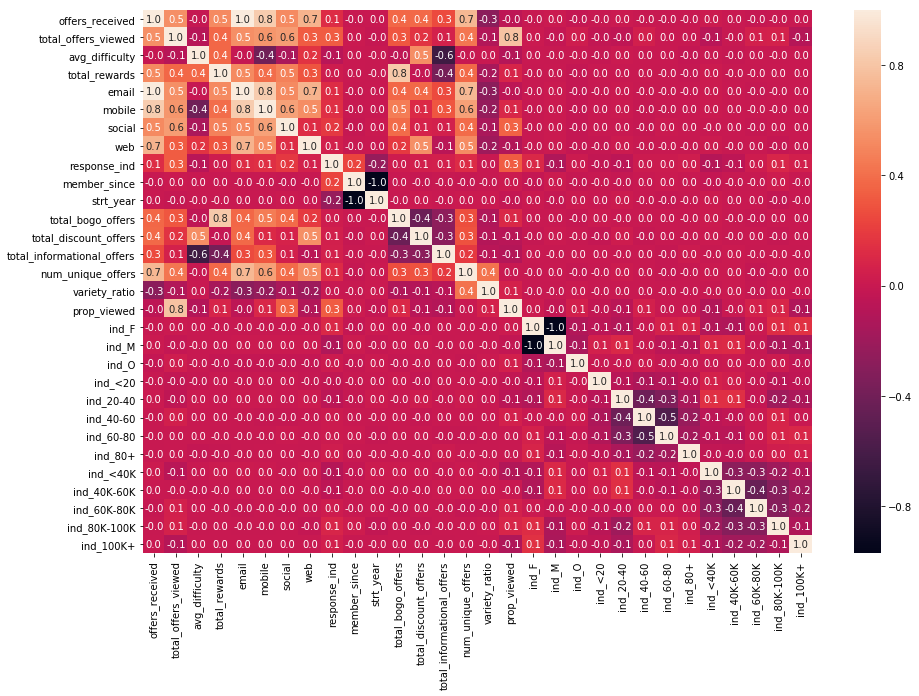

In [99]:
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(cust_data_agg.corr(), annot=True, fmt='.1f');

In [100]:
#Dropping highly inter correlated variables to avoid multi collinearity. 
# I am dropping high inter correlated variables with a correlation above 0.6
starbucks_final =cust_data_agg.drop(['ind_M','email','mobile','web','offers_received','total_offers_viewed','strt_year'],axis=1)
starbucks_final.head()

,cust_id,avg_difficulty,total_rewards,social,response_ind,member_since,total_bogo_offers,total_discount_offers,total_informational_offers,num_unique_offers,...,ind_<20,ind_20-40,ind_40-60,ind_60-80,ind_80+,ind_<40K,ind_40K-60K,ind_60K-80K,ind_80K-100K,ind_100K+
0,0009655768c64bdeb2e877511632db8f,5.00,9,3,1,619,1.0,2.0,2.0,5,...,0,1,0,0,0,0,0,1,0,0
1,0011e0d4e6b944f998e987f904e8c1e5,6.40,13,2,1,356,1.0,2.0,2.0,5,...,0,1,0,0,0,0,1,0,0,0
2,0020c2b971eb4e9188eac86d93036a77,8.00,24,5,1,1032,2.0,2.0,1.0,4,...,0,0,1,0,0,0,0,0,1,0
3,0020ccbbb6d84e358d3414a3ff76cffd,4.25,13,3,1,780,2.0,1.0,1.0,4,...,0,1,0,0,0,0,1,0,0,0
4,003d66b6608740288d6cc97a6903f4f0,8.00,9,3,1,558,0.0,3.0,2.0,4,...,0,1,0,0,0,0,0,1,0,0


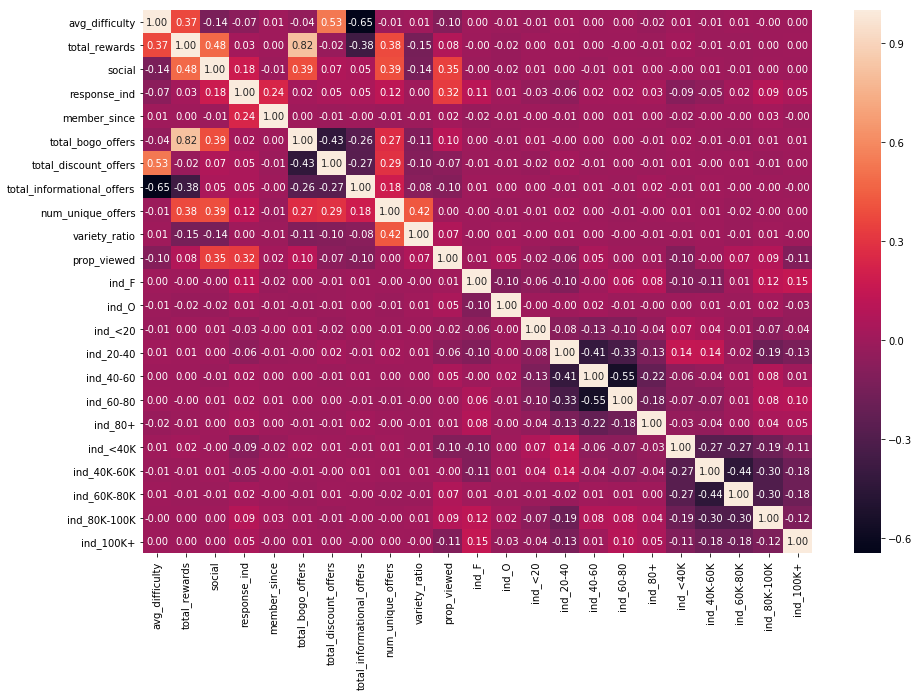

In [101]:
#Let's check the correlation again toc check if we missed any
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(starbucks_final.corr(), annot=True, fmt='.2f');

In [102]:
#Dropping total_rewards column as it has a high correlation with total bogo offers.
starbucks_final.drop(['total_rewards'],axis = 1,inplace = True)

In [103]:
#Now let's take a look at the columns in our final data
starbucks_final.columns

Index(['cust_id', 'avg_difficulty', 'social', 'response_ind', 'member_since',
       'total_bogo_offers', 'total_discount_offers',
       'total_informational_offers', 'num_unique_offers', 'variety_ratio',
       'prop_viewed', 'ind_F', 'ind_O', 'ind_<20', 'ind_20-40', 'ind_40-60',
       'ind_60-80', 'ind_80+', 'ind_<40K', 'ind_40K-60K', 'ind_60K-80K',
       'ind_80K-100K', 'ind_100K+'],
      dtype='object')

## Modeling

Now that our data is ready for modeling, let us create the target and features datasets.
Our target variable is response_ind (Response indicator -- which indicates whether an individual will respond to an offer or not)
If an individual has successfully completed atleast one offer, then I am considering that person as a responder.

In [104]:
X = starbucks_final.drop(['cust_id','response_ind'],axis = 1)
y = starbucks_final[['response_ind']]

In [105]:
print(X.shape)
print(y.shape)

(14820, 21)
(14820, 1)


In [106]:

# Split the 'features' and 'target' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y, 
                                                    test_size = 0.2, 
                                                    random_state = 42)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 11856 samples.
Testing set has 2964 samples.


**Logistic Regression Model**

In [107]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, y_pred)))
print("F1-score on testing data: {:.4f}".format(f1_score(y_test, y_pred)))

Accuracy score on testing data: 0.8323
F1-score on testing data: 0.9012


/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Let's look at the important features.

Text(0.5,0,'Relative Feature Importance')

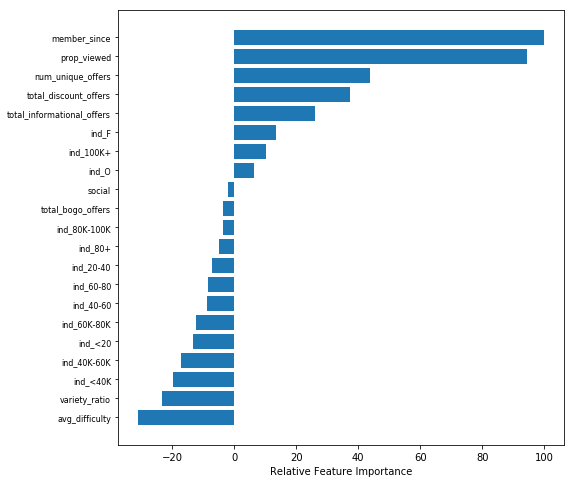

In [108]:
feature_importance = logreg.coef_[0]
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure(figsize=(8, 8))
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X.columns)[sorted_idx], fontsize=8)
featax.set_xlabel('Relative Feature Importance')

Now let's try a **RandomForest Classifier model**

In [109]:
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, y_pred)))
print("F1-score on testing data: {:.4f}".format(f1_score(y_test, y_pred)))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


Accuracy score on testing data: 0.8296
F1-score on testing data: 0.8995


Let's look at the important features from the Random forest model

Text(0.5,1,'Random Forest Estimated Feature Importance')

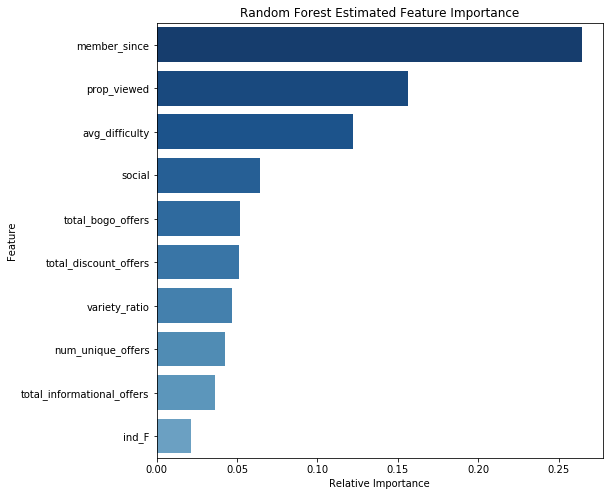

In [110]:
relative_importance = clf.feature_importances_
relative_importance = relative_importance / np.sum(relative_importance)

feature_importance =\
    pd.DataFrame(list(zip(X.columns,
                          relative_importance)),
                 columns=['feature', 'relativeimportance'])

feature_importance = feature_importance.sort_values('relativeimportance',
                                                    ascending=False)

feature_importance = feature_importance.reset_index(drop=True)

palette = sns.color_palette("Blues_r", feature_importance.shape[0])

plt.figure(figsize=(8, 8))
sns.barplot(x='relativeimportance',
            y='feature',
            data=feature_importance[:10],
            palette=palette)
plt.xlabel('Relative Importance')
plt.ylabel('Feature')
plt.title('Random Forest Estimated Feature Importance')

As we can see from the above 2 models, Logistic Regression is giving us a better accuracy and F1 - score than the Random forest classifier model.
We are getting good results from these models. So I am not fine tuning the model further by Hypertuning the parameters using Grid search method,
as this is a very basic model, that is through my model , I am just trying to predict whether a person will respond (successfuly complete) to an offer irrespective of the offer type.

Also if we look at the important features, both models are telling almost same story.


### Interpretation of Results

So from the results from our logistic model we can say that,

* Longtime members stand higher chance to respond to an offer.
* People who view offers more are highly likely to convert that offers to completion.

* Sending more unique offers, is likely to produce more responses.

* Sending more "Discount and Informational offers".

* Females are more likely to respond.

* People with higher income (income -100kplus) are likely to respond more.

* If the difficulty (minimum amount required to be spent) is more, then there is less chance to respond.

* Customers in lower age group are less likely to respond.

## Conclusion

Through this Project, we are trying to gauge effectiveness of promotional offers on consumer spends. We are trying to assess whether a customer will be responsive to promotional offers sent through Starbucks Reward Mobile App.
In Summary, it can be deduced that targeting High Income Female customers will yield better results. Sending Promotional Offers to long time members seems to be a more effective strategy. Discount Offers seem to be the most preferred promotional offer and seems to be highest success rate. 

From a business standpoint, getting a meaningful insight into customer response to various promotional campaigns, will be a valuable input while drafting future marketing & promotional offers and will help the business to channelise & target their  audience with tailor made offers that boost the effectiveness of marketing campaigns.

## Improvements

As with any Project, one can approach the core objective from various angles.Currently in this model I am considering Individuals who have successfully completed atleast one offer as a responder, irrespective of offer types. 

As a next step, we can formulate stringent conditions in choosing who are our responder to narrow our target audience. Inclusion of Offer type into models can help predict impact of customer demographics to particular offers.

We can build separate machine learning models to analyse offer type separately, or , we saw mis-attribution  by the Starbucks app, wherein rewards were given to customers incorrectly, it might be worth exploring the financial impact of such mis-attributions. 

So there are multitude of opportunities to explore within this dataset.

### External Resources

Throughout this project, I have taken the help of many external resouces like Stackoverflow, datascience blogs etc.
Please find below some of those.

* https://stackoverflow.com/questions/26760636/adding-datalabels-matplotlib-barchart
* https://kite.com/python/examples/1870/matplotlib-change-x-axis-tick-labels
* https://towardsdatascience.com/a-look-into-feature-importance-in-logistic-regression-models-a4aa970f9b0f
* https://towardsdatascience.com/solving-a-simple-classification-problem-with-python-fruits-lovers-edition-d20ab6b071d2
* https://www.datacamp.com/community/tutorials/random-forests-classifier-python
* https://machinelearningmastery.com/calculate-feature-importance-with-python/
* https://dfrieds.com/data-analysis/bin-values-python-pandas.html
* https://www.geeksforgeeks.org/python-pandas-series-nunique/
* https://www.shanelynn.ie/summarising-aggregation-and-grouping-data-in-python-pandas/
* https://www.ritchieng.com/machine-learning-evaluate-classification-model/
* https://www.geeksforgeeks.org/apply-function-to-every-row-in-a-pandas-dataframe/
* https://pbpython.com/pandas-qcut-cut.html
* http://www.datasciencemadesimple.com/reshape-using-stack-unstack-function-pandas-python/